NYC Taxi and Dask DataFrame
=================

In 2014 Chris Whong successfully submitted a FOIA request to obtain the records of all taxi rides in New York City for the year of 2013.  

http://chriswhong.com/open-data/foil_nyc_taxi/


The dataset is most easily downloaded from here

http://www.andresmh.com/nyctaxitrips/

There are numerous other analyses on the internet about this data.  Ryan Hafen has done a nice job collecting them

http://hafen.github.io/taxi/#background

Download and Unzip
---------------------

This dataset is around 31 GB total.  It comes in two sections, `trip` and `fare`.  We're only going to use the trip section to start.

In [ ]:
import os
if not os.path.exists('csv'):
    os.mkdir('csv')

In [ ]:
# Download trip data
!wget --directory-prefix csv https://nyctaxitrips.blob.core.windows.net/data/trip_data_{1..12}.csv.zip

In [ ]:
# Download fare data
!wget --directory-prefix csv https://nyctaxitrips.blob.core.windows.net/data/fare_data_{1..12}.csv.zip

Unzip
------

Zip files tend to be handled in operating-system specific ways.  We unzipped these files outside of Python.

In [1]:
!ls csv

trip_data_10.csv  trip_data_1.csv  trip_data_4.csv  trip_data_7.csv
trip_data_11.csv  trip_data_2.csv  trip_data_5.csv  trip_data_8.csv
trip_data_12.csv  trip_data_3.csv  trip_data_6.csv  trip_data_9.csv


Load with Dask DataFrame
----------------------------

We load this data into a dask dataframe using the `read_csv` function.  This has the exact same signature as `pandas.read_csv`.

In [2]:
import dask.dataframe as dd
df = dd.read_csv('csv/trip_data_*.csv')
df.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.750660
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.737770,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.976250,40.748528,-74.002586,40.747868


`read_csv` keyword arguments
--------------------------------

The data has a few quirks that we can work around with keyword arguments

1. The column names in the header have spaces in them while the rest of the data doesn't
2. We want to parse the datetimes into `pd.Timestamp` objects rather than leave them as strings

To accomplish this we'll use the machinery withing the `read_csv` function.  There are many options inherited from Pandas.

In [3]:
df = dd.read_csv('csv/trip_data_*.csv', 
                 skipinitialspace=True, 
                 parse_dates=['pickup_datetime', 'dropoff_datetime'])
df.dtypes

medallion                     object
hack_license                  object
vendor_id                     object
rate_code                      int64
store_and_fwd_flag            object
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
trip_time_in_secs              int64
trip_distance                float64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
dtype: object

Density Map of NYC Rides
----------------------------

We'll use Bokeh to plot out a density map of all start and end locations for all taxi rides.  


### Get sample of pickup and dropoff locations

First we'll pick out a few columns and use the `sample` method to pick out a random sample of 1% of all rides.  We'll then call `compute` on this data to convert the results into in-memory Pandas DataFrames that we can hand off to Bokeh.

This will require reading through all of the CSV files on disk.  CSV is not an efficient format so this can take a while (around 11 minutes on my notebook.)  We'll track our progress with the `ProgressBar` diagnostic.

In [4]:
sample = df.sample(frac=0.0001)
pickup = sample[['pickup_latitude', 'pickup_longitude']]

In [5]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    result = pickup.compute()  # compute to smaller Pandas DataFrame

[########################################] | 100% Completed | 11min  7.0s



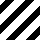
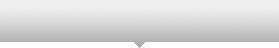
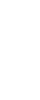
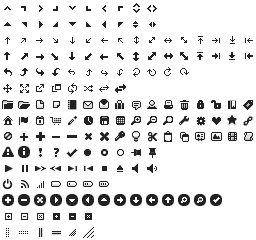
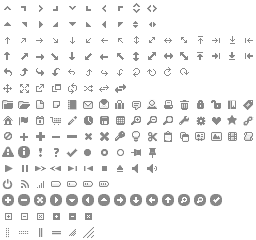
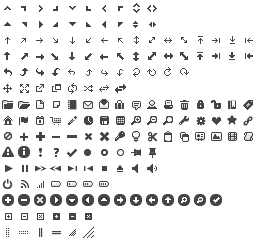
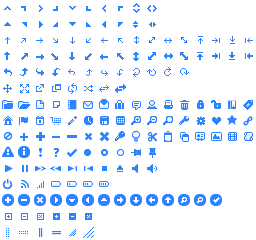
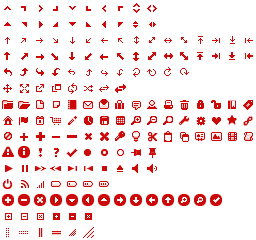
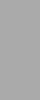
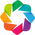
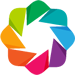
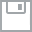
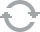
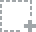
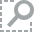
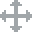
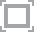
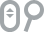

In [6]:
from bokeh.plotting import figure, show, output_notebook
output_notebook()

p = figure(title="Pickup Locations")
p.scatter(result.pickup_longitude, result.pickup_latitude, size=3, alpha=0.2, notebook=True)
show(p)

### Outliers

It looks like there are some silly data points lying around.  Lets restrict our data to a region around New York City and then resample.

In [7]:
df2 = df[(df.pickup_latitude > 40) &
         (df.pickup_latitude < 42) & 
         (df.pickup_longitude > -75) & 
         (df.pickup_longitude < -72)]

sample = df2.sample(frac=0.0001)
pickup = sample[['pickup_latitude', 'pickup_longitude']]

In [8]:
with ProgressBar():
    result = pickup.compute() # compute to Pandas DataFrame

[########################################] | 100% Completed | 11min 19.2s


In [9]:
p = figure(title="Pickup Locations")
p.scatter(result.pickup_longitude, result.pickup_latitude, size=3, alpha=0.2, notebook=True)
show(p)

Eleven Minutes is a Long Time
---------------------------------

In the small data case we load up our data into memory and then iterate quickly.  When data size grows beyond available memory limits we no longer have this luxury.  We need to repeatedly read from disk.  Unfortunately our CSV files take eleven minutes to read; this is too large of a delay to iterate interactively.  Fortunately we have a few options:

1.  Work on a subset of the data.  This could be by subsampling the rows as we did above for the plot and then working in Pandas or by taking out only the few columns that we need.  In this case you may use `dask.dataframe` for an initial pass over your data as you downsample before you pass off the smaller dataset to `pandas` to iterate quickly.
2.  Use more efficient on-disk storage mechanisms
3.  Cache commonly used results in memory

We've done subsetting above.  We'll do on-disk storage below and talk about opportunistic caching another time.

Efficient On-Disk Storage
-----------------------------

Good on-disk storage for DataFrames generally has the following characteristics

1.  Binary storage format:  We don't store values as text that needs to be parsed as integers.  This rules out CSV and JSON.  Most people recommend HDF5.
2.  Column Stores:  We store individual columns separately so that queries on just a few columns can load a small fraction of the dataset.  This rules out typical use of HDF5 and points people to projects like [`bcolz`](http://bcolz.blosc.org/)
3.  Categorical support:  Text is hard in Python.  Pandas Categoricals ([docs](http://pandas-docs.github.io/pandas-docs-travis/categorical.html), [blog](http://matthewrocklin.com/blog/work/2015/06/18/Categoricals/)) can speed this up when the text is often repeated.
4.  Compression:  Light compression can often increase data bandwidth from disk.  It's tricky to do right and depends on your data

Below we'll use the [`castra`](http://github.com/Blosc/castra) project to store our data on disk.  It supports all of the above and also support efficient range queries along a partitioned index.  To take advantage of this we'll first index our data by `pickup_datetime` to improve the efficiency of queries along this time axis.

*Warning: this will take a while.  It has to pass through our dataset a couple of times as a CSV file and then has to do a full on-disk shuffle of our data.  You will see two progress bars below.  It takes my machine about an hour to complete.*

In [10]:
with ProgressBar():
    c = df2.set_index('pickup_datetime', compute=False).to_castra('trip.castra', categories=True)

[########################################] | 100% Completed | 12min  2.3s
[########################################] | 100% Completed | 44min 13.7s


In [11]:
df3 = c.to_dask()
df3.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
pickup_datetime,,,,,,,,,,,,,
2013-01-01,3EC8BDDA70B148A45686D2BC098108AC,F153D0336BF48F93EC3913548164DDBD,VTS,1,NaN,2013-01-01 00:11:00,5,660,2.30,-73.978142,40.751530,-74.003105,40.732994
2013-01-01,E33E6723E2DCA218ADDC929EC832312E,9CA8140289190DAA94F385FA2C9A7304,VTS,1,NaN,2013-01-01 00:15:00,1,900,2.56,-73.997810,40.721516,-73.980232,40.751553
2013-01-01,EDC498F8AB44E4697ECB239CF11E001F,B1515483BAAFBC7DB7677DE5F46764A0,VTS,1,NaN,2013-01-01 00:10:00,3,600,4.97,-73.986130,40.722607,-73.953056,40.771873
2013-01-01,E4875E3542BE56CBBF7B5EABC0E7DD37,B7F843BC9199412ABC08DFF4DCBF3E02,VTS,1,NaN,2013-01-01 00:08:00,5,480,0.85,-73.977318,40.758751,-73.971481,40.752132
2013-01-01,5B649C3B5475C002D515BEF21192B504,B9C38E251CF991EF541D8EF357B262C7,VTS,1,NaN,2013-01-01 00:19:00,5,1140,8.48,-73.970207,40.762054,-73.938873,40.842186


### Indexed Fast Storage

Now our dataset is properly indexed by `pickup_datetime` (note that the first entries are on January 1st.)  And we can perform much faster queries.

In [12]:
with ProgressBar():
    print df3.passenger_count.mean().compute()

[########################################] | 100% Completed |  6.3s
1.7097364218


Range queries along the index can intelligently avoid loading data from disk.

In [13]:
with ProgressBar():
    print df3.loc['2013-04': '2013-07'].passenger_count.mean().compute()

[########################################] | 100% Completed | 15.2s
1.71216219576


What was previously a full scan of 20GB of CSV files and an eleven minute coffee break is now a few second query.

Below we'll do our previous calculation of pulling off four columns and downsampling considerably. This will take a bit longer because the floating point data is less compressible and because there is considerably more of it.

In [14]:
pickup = df3[['pickup_latitude', 'pickup_longitude']].sample(frac=0.0001)

with ProgressBar():
    result = pickup.compute()

[########################################] | 100% Completed | 25.2s


Complex Operations
---------------------

It's worth mentioning that `dask.dataframe` can manage more complex Pandas operations as well.

Lets look at the distribution of trip distances.  We compute distance, convert to meters, bin the results and plot with Bokeh.  This will take about a minute.

In [15]:
km_per_degree_latitude = 110.0  # at 40 degrees 
km_per_degree_longitude = 85.0  # from http://www.csgnetwork.com/degreelenllavcalc.html

with ProgressBar():
    distance = ((km_per_degree_latitude * (df3.pickup_latitude - df3.dropoff_latitude))**2
              + (km_per_degree_longitude * (df3.pickup_longitude - df3.dropoff_longitude))**2)**0.5
    hist = (distance // 1).value_counts().compute().sort_index()  # truncate then count
hist.head()

[########################################] | 100% Completed | 41.8s


0    27131425
1    50303558
2    31938869
3    18334931
4    11534167
dtype: int64

In [16]:
p = figure(title="Binned distance frequencies (degrees)",
           y_axis_type="log")
p.line(hist.loc[:100].index.values, hist.loc[:100].values)
show(p)

There is an interesting spike around twenty kilometers.  This is roughly the distance between downtown/midtown Manhattan and LaGuardia airport.